# LQ Approximation with `QuantEcon.py`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

In [2]:
# matplotlib settings
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

We consider a dynamic maximization problem with

* reward function $f(s, x)$,
* state transition function $g(s, x)$, and
* discount rate $\delta$,

where $s$ and $x$ are the state and the control variables, respectively
(we follow Miranda-Fackler in notation).

Let $(s^*, x^*)$ denote the steady state state-control pair,
and write
$f^* = f(s^*, x^*)$, $f_i^* = f_i(s^*, x^*)$, $f_{ij}^* = f_{ij}(s^*, x^*)$,
$g^* = g(s^*, x^*)$, and $g_i^* = g_i(s^*, x^*)$ for $i, j = s, x$.

First-order expansion of $g$ around $(s^*, x^*)$:
$$
\begin{align*}
g(s, x)
&\approx g^* + g_s^* (s - s^*) + g_x^* (x - x^*) \\
&= A \begin{pmatrix}1 \\ s\end{pmatrix} + B x,
\end{align*}
$$
where

* $A =
  \begin{pmatrix}
  1 & 0 \\
  g^* - \nabla g^{*\mathrm{T}} z^* & g_s^*
  \end{pmatrix}$,

* $B =
  \begin{pmatrix}
  0 \\ g_x^*
  \end{pmatrix}$

with $z^* = (s^*, x^*)^{\mathrm{T}}$ and $\nabla g^* = (g_s^*, g_x^*)^{\mathrm{T}}$.

Second-order expansion of $f$ around $(s^*, x^*)$:
$$
\begin{align*}
f(s, x)
&\approx f^* + f_s^* (s - s^*) + f_x^* (x - x^*) +
         \frac{1}{2} f_{ss}^* (s - s^*)^2 + f_{sx}^* (s - s^*) (x - x^*) +
         \frac{1}{2} f_{xx}^* (x - x^*)^2 \\
&= \begin{pmatrix}
   1 & s & x
   \end{pmatrix}
   \begin{pmatrix}
   f^* - \nabla f^{*\mathrm{T}} z^* + \frac{1}{2} z^{*\mathrm{T}} D^2 f^* z^* &
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*)^{\mathrm{T}} \\
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*) & \frac{1}{2} D^2 f^*
   \end{pmatrix}
   \begin{pmatrix}
   1 \\ s \\ x
   \end{pmatrix},
\end{align*}
$$
where
$\nabla f^* = (f_s^*, f_x^*)^{\mathrm{T}}$ and
$$
D^2 f^* =
\begin{pmatrix}
f_{ss}^* & f_{sx}^* \\
f_{sx}^* & f_{xx}^*
\end{pmatrix}.
$$

Let
$$
\begin{align*}
r(s, x)
&= -
   \begin{pmatrix}
   1 & s & x
   \end{pmatrix}
   \begin{pmatrix}
   f^* - \nabla f^{*\mathrm{T}} z^* + \frac{1}{2} z^{*\mathrm{T}} D^2 f^* z^* &
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*)^{\mathrm{T}} \\
   \frac{1}{2} (\nabla f^* - D^2 f^* z^*) & \frac{1}{2} D^2 f^*
   \end{pmatrix}
   \begin{pmatrix}
   1 \\ s \\ x
   \end{pmatrix} \\
&= \begin{pmatrix}
   1 & s
   \end{pmatrix}
   R
   \begin{pmatrix}
   1 \\ s
   \end{pmatrix} +
   2 x N
   \begin{pmatrix}
   1 \\ s
   \end{pmatrix} +
   Q x,
\end{align*}
$$
where

* $R = -
  \begin{pmatrix}
  f^* - \nabla f^{*\mathrm{T}} z^* + \frac{1}{2} z^{*\mathrm{T}} D^2 f^* z^* &
  \frac{1}{2} [f_s^* - (f_{ss}^* s^* + f_{sx}^* x^*)] \\
  \frac{1}{2} [f_s^* - (f_{ss}^* s^* + f_{sx}^* x^*)] & \frac{1}{2} f_{ss}^*
  \end{pmatrix}$,

* $N = -
  \begin{pmatrix}
  \frac{1}{2} [f_x^* - (f_{sx}^* s^* + f_{xx}^* x^*)] & \frac{1}{2} f_{sx}^*
  \end{pmatrix}$.

* $Q = -\frac{1}{2} f_{xx}^*$.

Remarks:

* We are going to *minimize* the objective function.

In [3]:
def approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount):
    """
    Return an approximating LQ instance.
    
    Gradient of f: Df_star = np.array([f_s, f_x])
    Hessian of f: DDf_star = np.array([[f_ss, f_sx], [f_sx, f_xx]])
    Gradient of g: Dg_star = np.array([g_s, g_x])
    
    """
    n = 2
    k = 1
    sx_star = np.array([s_star, x_star])
    
    # (1, s)' R (1, s) + 2 x N (1, s) + x Q x
    Q = np.empty((k, k))
    R = np.empty((n, n))
    N = np.empty((k, n))
    R[0, 0] = -(f_star - Df_star @ sx_star + (sx_star @ DDf_star @ sx_star) / 2)
    R[1, 1], N[0, 1], N[0, 1], Q[0, 0] = -DDf_star.ravel() / 2
    R[1, 0], N[0, 0] = -(Df_star - DDf_star @ sx_star).ravel() / 2
    R[0, 1] = R[1, 0]
    
    # A (1, s) + B x + C w
    A = np.empty((n, n))
    B = np.empty((n, k))
    C = np.zeros((n, 1))
    A[0, 0], A[0, 1], B[0, 0] = 1, 0, 0
    A[1, 0] = g_star - Dg_star @ sx_star
    A[1, 1], B[1, 0] = Dg_star.ravel()
    
    lq = qe.LQ(Q, R, A, B, C, N, beta=discount)
    return lq

## Optimal Economic Growth

We consider the following optimal growth model from Miranda and Fackler, Section 9.7.1:

* $f(s, x) = \dfrac{(s - x)^{1-\alpha}}{1-\alpha}$,
* $g(s, x) = \gamma + x^{\beta}$.

In [4]:
alpha = 0.2
beta = 0.5
gamma = 0.9
discount = 0.9

Function definitions:

In [5]:
f = lambda s, x: (s - x)**(1 - alpha) / (1 - alpha)
f_s = lambda s, x: (s - x)**(-alpha)
f_x = lambda s, x: -f_s(s, x)
f_ss = lambda s, x: -alpha * (s - x)**(-alpha - 1)
f_sx = lambda s, x: -f_ss(s, x)
f_xx = lambda s, x: f_ss(s, x)

g = lambda s, x: gamma * x + x**beta
g_s = lambda s, x: 0
g_x = lambda s, x: gamma + beta * x**(beta - 1)

Steady state:

In [6]:
x_star = ((discount * beta) / (1 - discount * gamma))**(1 / (1 - beta))
s_star = gamma * x_star + x_star**beta
s_star, x_star

(7.416897506925212, 5.6094182825484795)

`(s_star, x_star)` satisfies the Euler equations:

In [7]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

1.1102230246251565e-16

Construct $f^*$, $\nabla f^*$, $D^2 f^*$, $g^*$, and $\nabla g^*$:

In [8]:
f_star = f(s_star, x_star)
Df_star = np.array([f_s(s_star, x_star), f_x(s_star, x_star)])
DDf_star = np.array([[f_ss(s_star, x_star), f_sx(s_star, x_star)],
                     [f_sx(s_star, x_star), f_xx(s_star, x_star)]])
g_star = g(s_star, x_star)
Dg_star = np.array([g_s(s_star, x_star), g_x(s_star, x_star)])

## LQ Approximation

Generate an LQ instance that approximates our dynamic optimization problem:

In [9]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

## Solution by `LQ.stationary_values`

Solve the LQ problem:

In [10]:
P, F, d = lq.stationary_values()
P, F, d

(array([[ -1.32117956e+01,  -4.80629345e-01],
        [ -4.80629345e-01,   4.91486986e-03]]),
 array([[ 1.06578947, -0.9       ]]),
 0.0)

The optimal value function (of the LQ minimization problem):

In [11]:
V = lambda s: np.array([1, s]) @ P @ np.array([1, s]) + d

The value at $s^*$:

In [12]:
V(s_star)

-20.070983979777338

In [13]:
-f_star / (1 - lq.beta)

-20.070983979777242

The optimal policy function:

In [14]:
X = lambda s: -(F @ np.array([1, s]))[0]

The optimal choice at $s^*$:

In [15]:
X(s_star)

5.6094182825484609

In [16]:
x_star

5.6094182825484795

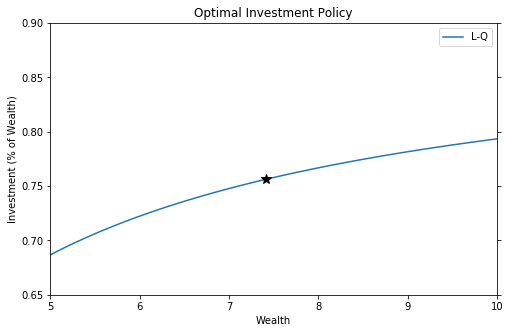

In [17]:
X = np.vectorize(X)
s_min, s_max = 5, 10
ss = np.linspace(s_min, s_max, 50)
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ss, X(ss)/ss, label='L-Q')
ax.plot(s_star, x_star/s_star, '*', color='k', markersize=10)
ax.set_xlim(s_min, s_max)
ax.set_ylim(0.65, 0.9)
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(right='on')
ax.legend()
plt.show()

## Renewable Resource Management

Consider the renewable resource management model from Miranda and Fackler, Section 9.7.2:

* $f(s, x) = \dfrac{(s - x)^{1-\gamma}}{1-\gamma} - \kappa (s - x)$,
* $g(s, x) = \alpha x - 0.5 \beta x^2$.

In [18]:
alpha = 4.0
beta = 1.0
gamma = 0.5
kappa = 0.2
discount = 0.9

In [19]:
f = lambda s, x: (s - x)**(1 - gamma) / (1 - gamma) - kappa * (s - x)
f_s = lambda s, x: (s - x)**(-gamma) - kappa
f_x = lambda s, x: -f_s(s, x)
f_ss = lambda s, x: -gamma * (s - x)**(-gamma - 1)
f_sx = lambda s, x: -f_ss(s, x)
f_xx = lambda s, x: f_ss(s, x)

g = lambda s, x: alpha * x - 0.5 * beta * x**2
g_s = lambda s, x: 0
g_x = lambda s, x: alpha - beta * x

In [20]:
x_star = (discount * alpha - 1) / (discount * beta)
s_star = (alpha**2 - 1/discount**2) / (2 * beta)
s_star, x_star

(7.382716049382716, 2.888888888888889)

In [21]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

5.551115123125783e-17

In [22]:
f_star = f(s_star, x_star)
Df_star = np.array([f_s(s_star, x_star), f_x(s_star, x_star)])
DDf_star = np.array([[f_ss(s_star, x_star), f_sx(s_star, x_star)],
                     [f_sx(s_star, x_star), f_xx(s_star, x_star)]])
g_star = g(s_star, x_star)
Dg_star = np.array([g_s(s_star, x_star), g_x(s_star, x_star)])

In [23]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

In [24]:
P, F, d = lq.stationary_values()
P, F, d

(array([[ -3.12605147e+01,  -1.55238638e-01],
        [ -1.55238638e-01,   2.62431197e-03]]),
 array([[ 3.75555556, -0.9       ]]),
 0.0)

In [25]:
V = lambda s: np.array([1, s]) @ P @ np.array([1, s]) + d

In [26]:
V(s_star)

-33.409643519765581

In [27]:
-f_star / (1 - lq.beta)

-33.409643519765496

In [28]:
X = lambda s: -(F @ np.array([1, s]))[0]

In [29]:
X(s_star)

2.8888888888889128

In [30]:
x_star

2.888888888888889

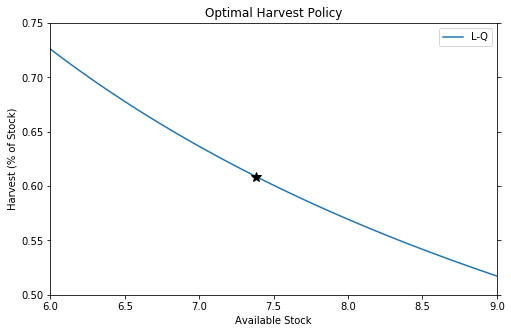

In [31]:
X = np.vectorize(X)
s_min, s_max = 6, 9
ss = np.linspace(s_min, s_max, 50)
harvest = ss - X(ss)
h_star = s_star - x_star
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest (% of Stock)"
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ss, harvest/ss, label='L-Q')
ax.plot(s_star, h_star/s_star, '*', color='k', markersize=10)
ax.set_xlim(s_min, s_max)
ax.set_ylim(0.5, 0.75)
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(right='on')
ax.legend()
plt.show()

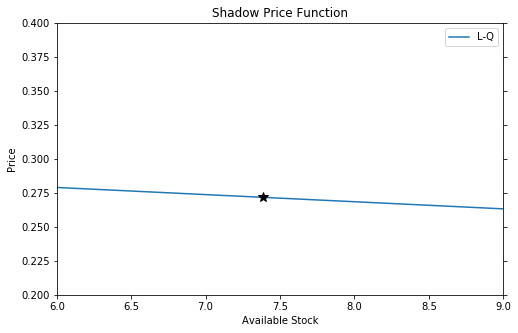

In [32]:
shadow_price = lambda s: -2 * (P @ [1, s])[1]
shadow_price = np.vectorize(shadow_price)
title = "Shadow Price Function"
ylabel = "Price"
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ss, shadow_price(ss), label='L-Q')
ax.plot(s_star, shadow_price(s_star), '*', color='k', markersize=10)
ax.set_xlim(s_min, s_max)
ax.set_ylim(0.2, 0.4)
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.tick_params(right='on')
ax.legend()
plt.show()